# Introduction to Data Science – Homework 6
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 23, 11:59pm.

In Part 1 of this homework you will scrape github repositories and organize the information in a Pandas dataframe. In Part 2, you will use linear regression to gain meaningful insights. 

## Your Data
First Name: Travis
<br>
Last Name: Tiner
<br>
E-mail: u0769566@utah.edu
<br>
UID: u0769566
<br>

In [1]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import requests
import urllib.request


import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

### 1. Scrape Github Repository List and Repository Information using BeautifulSoup
In this part you will explore over 2 million Github repositories. You are going to scrape [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

### 1.1. Check whether you are permitted to scrape the data
Before you start to scrape any website you should go through the terms and services or similar pages of the website. Almost all websites post conditions to use their data. Check the terms of [https://github.com/](https://github.com/) to see whether the site permits you to scrape their data or not. Are you sure you are allowed to scrape?

**Your Interpretation:**
TODO

Their terms state that scraping is permitted as long as you use the data for research purposes, and you're only accessing public content. So we are okay to continue.

### Task 1.2 Download the website

Download the **first ten** pages of the list of highly starred repositories here: 

https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories

To avoid sending too many requests to the server, make sure that your querying code is in a sperate cell from anything else, so that you don't have to re-run it needlessly. 

**Warning:** while we haven't experienced any problems, exepct that github will temporarily block access if you scrape their website relentlessly. Make sure to be responsible. Also, don't do this last minute – if you're blocked for e.g., 24 hours that could impact your timeline.

Now read the html text in python and create a soup object.

In [86]:
import urllib.request
import time
html = dict()
for i in sc.arange(1,11):
    
    url = "https://github.com/search?o=desc&p=" + str(i) + "&q=stars%3A%3E1&s=stars&type=Repositories"
    with urllib.request.urlopen(url) as response:
        html[i] = response.read()
        html[i] = html[i].decode('utf-8')
    time.sleep(11)

In [3]:
html_1 = str(html[1]) + str(html[2]) + str(html[3]) + str(html[4]) + str(html[5]) + str(html[6]) + str(html[7]) + str(html[8]) + str(html[9]) + str(html[10])
with open('github_repos.html', 'w') as new_file:
    new_file.write(html_1)

In [4]:
list_soup = BeautifulSoup(open("github_repos.html", encoding='utf-8'), "html.parser")

### 1.3. Extract Data

Extract the foolowing data for each repository, and create a Pandas Dataframe with a row for each repository and a column for each of these datums. 

1. Name of the repository
+ URL of the repository 
+ Number of Contributors 
+ Programming Language Used 
+ Number of stars 
+ Number of issues
+ Number of forks 
+ Length of readme file.

Note that you will frist have to extract links from the soup that you just scraped earlier, and then download the repository pages to retreive most of the data. 

Refer to lecture 12 for details on how to do this. Make sure to use the web inspector to identify the relevant structures. 

Save the dataframe you created to a new file `project_info.csv` and include this in your submission.

In [5]:
links = []
url = "https://github.com"
for name in list_soup.find_all(class_="col-8 pr-3"):
    link_tail = name.find("a").get("href")
    link = url + str(link_tail)
    name_of_repo = name.find("a").get_text()
    links.append(link)


In [6]:
#Get HTML for all 100 repos.
all_repos = ""
for i in range(0,len(links)):
    url = links[i]
    html = {}
    with urllib.request.urlopen(url) as response:
        html[i] = response.read()
        html[i] = html[i].decode('utf-8')
    all_repos = all_repos + str(html[i])
    time.sleep(9)


In [7]:
#save that HTML file
with open('github_repos_pages.html', 'w') as new_file:
    new_file.write(all_repos)

In [8]:
repos_soup = BeautifulSoup(open("github_repos_pages.html", encoding='utf-8'), "html.parser")

In [48]:
#Get name, language, and URL 
info = []
for name in list_soup.find_all(class_="col-8 pr-3"):
    name_of_repo = name.find("a").get_text()
    info.append(name_of_repo)
df = pd.DataFrame(columns=['Name','URL','Contributors','Programming_Language','Stars','Issues','Forks','Readme_Length'])
df['Name'] = info
info = []
for x in list_soup.find_all(class_="d-table-cell col-2 text-gray pt-2"):
    language = x.get_text()
    language = language.replace("\n","")
    language = language.strip()
    info.append(language)
df['Programming_Language'] = info
df['URL'] = links


In [49]:
stars = []
forks = []
for x in repos_soup.find_all(class_="pagehead-actions"):
    s = x("li")[1].get_text()
    s = s.replace("Star","")
    s = s.replace("\n","")
    s = s.strip()
    stars.append(s)
    f = x("li")[2].get_text()
    f = f.replace("Fork","")
    f = f.replace("\n","")
    f = f.strip()
    forks.append(f)
df['Stars'] = stars
df['Forks'] = forks


In [50]:
contributors = []
for x in repos_soup.find_all(class_="numbers-summary"):
    c = x("li")[3].get_text()
    c = c.replace("contributors","")
    c = c.replace("\n","")
    c = c.strip()
    contributors.append(c)
df['Contributors'] = contributors

In [51]:
issues = []
for x in repos_soup.find_all(class_="reponav js-repo-nav js-sidenav-container-pjax container"):
    i = x("a")[1].find('span',{'class':"Counter"}).text
    i = i.strip()
    issues.append(i)
df['Issues'] = issues

In [52]:
length = []
for x in repos_soup.find_all(id="readme"):
    if x.find(class_="markdown-body entry-content"):
        l = len(x.find(class_="markdown-body entry-content").text)
        length.append(l)
    else:
        l = len(x.find(class_="plain").text)
        length.append(l)
df['Readme_Length'] = length
df = df.replace("",np.nan)
df

,Name,URL,Contributors,Programming_Language,Stars,Issues,Forks,Readme_Length
0,freeCodeCamp/freeCodeCamp,https://github.com/freeCodeCamp/freeCodeCamp,731,JavaScript,"291,623",164,"13,481",2785
1,twbs/bootstrap,https://github.com/twbs/bootstrap,983,CSS,"122,084",319,"57,735",5018
2,EbookFoundation/free-programming-books,https://github.com/EbookFoundation/free-progra...,981,NaN,"101,511",17,"25,815",1573
3,tensorflow/tensorflow,https://github.com/tensorflow/tensorflow,"1,343",C++,"90,046","1,206","58,489",3014
4,facebook/react,https://github.com/facebook/react,"1,167",JavaScript,"88,860",326,"16,817",3297
5,vuejs/vue,https://github.com/vuejs/vue,167,JavaScript,"84,426",97,"12,372",2812
6,sindresorhus/awesome,https://github.com/sindresorhus/awesome,324,NaN,"78,653",38,"10,312",12873
7,getify/You-Dont-Know-JS,https://github.com/getify/You-Dont-Know-JS,159,NaN,"76,196",110,"13,759",2645
8,d3/d3,https://github.com/d3/d3,121,JavaScript,"72,713",3,"18,776",1506
9,airbnb/javascript,https://github.com/airbnb/javascript,379,JavaScript,"66,715",89,"12,761",71729


In [53]:
df.to_csv('project_info.csv')

### 2. Use linear regression to analyze the Github repository data

In this part, you will analyze the data collectd in Part 1 using regression tools. The goal is to identify properties that make a repository popular. 

First, load the project_info.csv file in again. **We need you to do this so that we can run your code below withouth having to run your scraping code.**

In [54]:
# this loads the data from the project_info.csv file 
project_info = pd.read_csv('project_info.csv', index_col=0)
project_info.head()

,Name,URL,Contributors,Programming_Language,Stars,Issues,Forks,Readme_Length
0,freeCodeCamp/freeCodeCamp,https://github.com/freeCodeCamp/freeCodeCamp,731,JavaScript,"291,623",164,"13,481",2785
1,twbs/bootstrap,https://github.com/twbs/bootstrap,983,CSS,"122,084",319,"57,735",5018
2,EbookFoundation/free-programming-books,https://github.com/EbookFoundation/free-progra...,981,NaN,"101,511",17,"25,815",1573
3,tensorflow/tensorflow,https://github.com/tensorflow/tensorflow,"1,343",C++,"90,046","1,206","58,489",3014
4,facebook/react,https://github.com/facebook/react,"1,167",JavaScript,"88,860",326,"16,817",3297


### 2.1. Reformat the data into useful datatypes

1. Print the data types for the columns of your dataframe
+ Reformat the colums Issues, Forks, Stars, and Contributers to be integer data
+ There is one repository flagged as having infinite contributers (the Linux kernel). We'll assume that it in fact has 15000 contributors (about twice as much as the next project). 

In [55]:
project_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
Name                    100 non-null object
URL                     100 non-null object
Contributors            100 non-null object
Programming_Language    86 non-null object
Stars                   100 non-null object
Issues                  100 non-null object
Forks                   100 non-null object
Readme_Length           100 non-null int64
dtypes: int64(1), object(7)
memory usage: 7.0+ KB


In [56]:
project_info['Contributors'] = project_info['Contributors'].str.replace(',', '')
project_info['Contributors'] = project_info['Contributors'].str.replace('∞', '15000')
project_info['Contributors'] = project_info['Contributors'].astype(int)

In [57]:
project_info['Stars'] = project_info['Stars'].str.replace(',', '')
project_info['Stars'] = project_info['Stars'].astype(int)

In [58]:
project_info['Issues'] = project_info['Issues'].str.replace(',', '')
project_info['Issues'] = project_info['Issues'].astype(int)

In [59]:
project_info['Forks'] = project_info['Forks'].str.replace(',', '')
project_info['Forks'] = project_info['Forks'].astype(int)

In [60]:
project_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
Name                    100 non-null object
URL                     100 non-null object
Contributors            100 non-null int64
Programming_Language    86 non-null object
Stars                   100 non-null int64
Issues                  100 non-null int64
Forks                   100 non-null int64
Readme_Length           100 non-null int64
dtypes: int64(5), object(3)
memory usage: 7.0+ KB


### Task 2.2 Describe the data

+ Get an overview of the data using the describe function.
+ Compute the correlation matrix, visualize it with a heat map.
+ Visualize the correlations by making a scatterplot matrix.
+ Interprete what you see.

You can re-use code from your previous homework here.

In [61]:
project_info.describe()

,Contributors,Stars,Issues,Forks,Readme_Length
count,100.000000,100.000000,100.000000,100.00000,100.000000
mean,711.100000,43141.600000,575.740000,9554.85000,11636.110000
std,1650.195223,30668.016004,972.157162,8837.96467,21058.743616
min,2.000000,26496.000000,0.000000,660.00000,324.000000
25%,126.250000,29831.500000,31.750000,4772.25000,1877.000000
50%,288.500000,33536.000000,173.000000,7461.50000,3308.000000
75%,731.250000,43571.250000,542.500000,11564.75000,9687.250000
max,15000.000000,291623.000000,4387.000000,58489.00000,104323.000000


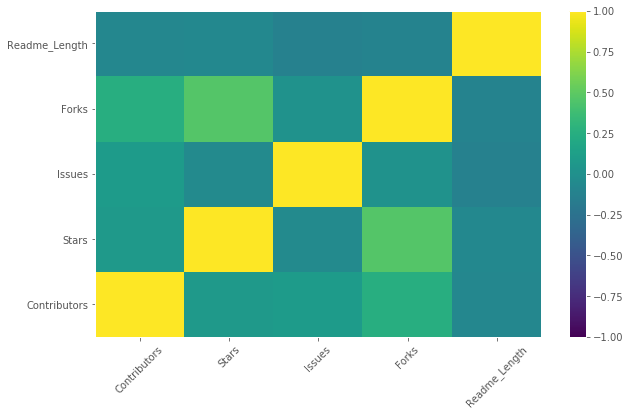

In [63]:
features = ["Contributors","Stars","Issues","Forks","Readme_Length"]
plt.xticks(np.arange(15)+.5, features, rotation=45)
plt.yticks(np.arange(15)+.5, features)

heatmap = plt.pcolor(project_info.corr(),vmin=-1,vmax=1)
plt.colorbar(heatmap)

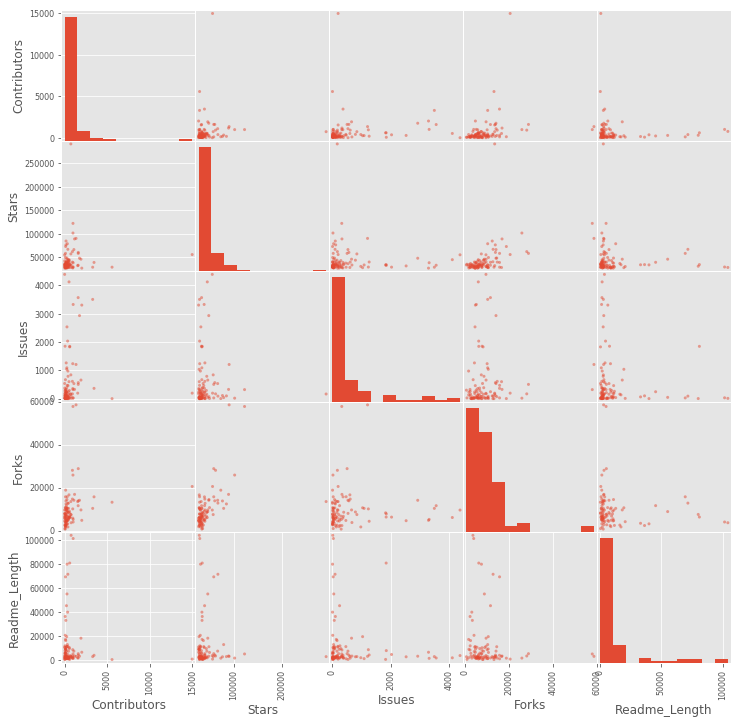

In [64]:
project_info_sub = project_info[features]
pd.plotting.scatter_matrix(project_info_sub,figsize=(12,12));

**Your Interpretation:** TODO

It's hard to tell if there are any two factors that have any sort of correlation. From our heat map we can see that Number of Forks and Number of Stars are the most correlated but it is still small.

### 2.3. Linear regression

1. First use linear regression to try to predict the number of Stars based on Forks, Contributors, Issues, and Readme Length. Explain why this is not a very good model by discussing the R-squared , F-statistic p-value, and coefficient  p-values. 
+ Develop another model which is better. Explain why it is better and interpret your results. 

In [65]:
Stars_Model = sm.ols('Stars ~ Forks + Contributors + Issues + Readme_Length',data=project_info).fit()
Stars_Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     6.724
Date:                Thu, 22 Feb 2018   Prob (F-statistic):           8.26e-05
Time:                        11:40:44   Log-Likelihood:                -1162.0
No. Observations:                 100   AIC:                             2334.
Df Residuals:                      95   BIC:                             2347.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.955e+04   4875.605      6.062      0.000    1.99e+04    3.92e+04
Forks             1.6415      0.326      5.030      0.000       0.994       2.289
Contributors     -0.8429      1.748     -0.482      0.631      -4.313       2.628
Issues           -1.9182      2.892     -0.663      0.509      -7.659       3.823
Readme_Length    -0.0338      0.134     -0.252      0.801      -0.300       0.232
==============================================================================
Omnibus:                      180.710   Durbin-Watson:                   1.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16458.761
Skew:                           7.185   Prob(JB):                         0.00
Kurtosis:                      64.185   Cond. No.                     4.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is not a very good model, since the R-squared is rather low at .221. Our F-statistic P-value is .0000826, which is rather small, which would indicate that the null hypothesis that all of the coefficients are zero is false. Digging in deeper, however, we notice that the p-values for each specific coefficient are only small for Forks. The other coefficients are high, indicating that they are not significant.

In [85]:
Stars_Model = sm.ols('Stars ~ Forks*Issues',data=project_info).fit()
Stars_Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     10.21
Date:                Sat, 24 Feb 2018   Prob (F-statistic):           6.75e-06
Time:                        09:06:49   Log-Likelihood:                -1160.6
No. Observations:                 100   AIC:                             2329.
Df Residuals:                      96   BIC:                             2340.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      2.39e+04   5173.135      4.621      0.000    1.36e+04    3.42e+04
Forks            2.2106      0.464      4.760      0.000       1.289       3.132
Issues           6.3889      5.579      1.145      0.255      -4.685      17.463
Forks:Issues    -0.0010      0.001     -1.728      0.087      -0.002       0.000
==============================================================================
Omnibus:                      182.451   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17253.250
Skew:                           7.300   Prob(JB):                         0.00
Kurtosis:                      65.671   Cond. No.                     2.35e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I still wasn't able to find a very good model, but this model was at least better than the previous one. I got an R^2 value of .242, with a fairly small F-statistic P-value. The one problem with htis model, besides the low R^2, is that our P-value for the Issues coefficient is .255.

** Your interpretation:** TODO